# Text clustering using CNN 

### Import module

In [1]:
# modules
import os
import numpy as np
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from utils import target

# created own library for dealing with embedding
from utils.embedding import Embeddor

LOGDIR = './tensorflow_summaries'
DATADIR = './data/short_texts'

plt.style.use("ggplot")
%matplotlib inline

Using TensorFlow backend.


### Load short texts dataset

In [2]:
path_data = os.path.join(DATADIR, "StackOverflow.txt")
path_label = os.path.join(DATADIR, "StackOverflow_gnd.txt")

In [3]:
short_texts = list()
labels = list()

with open(path_data, 'r') as f:
    n = 0
    for line in f:
        n += 1
        short_texts.append(line.rstrip('\n').lower())
        
with open(path_label, 'r') as f:
    for line in f:
        labels.append(int(line.rstrip('\n')) - 1)
        
print("There is %d short texts" % n)
unique_labels =  np.unique(labels)
print("Labels: ", unique_labels)
n_clusters = len(unique_labels)
print("There is %d clusters" % n_clusters)

There is 20000 short texts
Labels:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
There is 20 clusters


### Load embeddings

In [4]:
%%time

# parameters
n_emb = int(3 * 1e5)
src = "./embeddings"
emb_name = os.listdir(src)[-1]
print("Embedding: %s" % emb_name)
src_emb = os.path.join(src, emb_name)

# embeddor
embeddor = Embeddor(notebook_display=True)
emb_mat = embeddor.load_emb(src_emb, n_emb)
print("Embedding shape: {}".format(emb_mat.shape))

Embedding: fasttext.wiki.en.vec



Embedding shape: (300001, 300)
CPU times: user 27.9 s, sys: 1.83 s, total: 29.7 s
Wall time: 28 s


### Create targets

#### LSA features

In [5]:
tfidf_vectors = TfidfVectorizer(ngram_range=(1, 1)).fit_transform(short_texts)
norm_vectors = normalize(tfidf_vectors)
lsa_vectors = TruncatedSVD(n_components=20).fit_transform(norm_vectors)
n, d = lsa_vectors.shape
print(n, d)

20000 20


#### Subsampling because spectral embedding is too slow

In [6]:
# random sampling of index
np.random.seed(10)
n_subset = 5000
idxs = np.random.randint(0, n, (n_subset,))

# indexing dataset 
lsa_subset = lsa_vectors[idxs]
labels_subset = [labels[i] for i in idxs]
short_texts_subset = [short_texts[i] for i in idxs]

#### Laplacian Eigenmaps

In [7]:
%%time
eigen_vectors = target.laplacian_eigenmaps(lsa_subset, n_neighbors=20, subdim=20, n_jobs=10)

Fitting nearest neighbors
Creation of affinity matrix
Creation of heat kernel affinity matrix
Spectral embedding
CPU times: user 51.9 s, sys: 552 ms, total: 52.4 s
Wall time: 7.02 s


 #### Binarize target vectors

In [8]:
targets = target.binarize(eigen_vectors)

### CNN helper functions 

#### TensorFlow functions

In [9]:
# height-wise convolution
def apply_conv1d(x, filter_size, stride, out_size, bias=True, wide=True):
    if wide:
        pad_size = filter_size - 1
        paddings = [[0, 0], [pad_size, pad_size], [0, 0], [0, 0]]
        x = tf.pad(x, paddings=paddings)
    width = x.get_shape().as_list()[2]
    filter_shape = [filter_size, width, 1, out_size]
    W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name='W')
    conv = tf.nn.conv2d(x, 
                        W, 
                        strides=[1, stride, 1, 1], 
                        padding='VALID',
                        data_format='NHWC',
                        name='conv1d')
    if bias:
        b = tf.Variable(tf.constant(0.1, shape=[out_size]), name='b')
        conv = tf.nn.bias_add(conv, b)
    return conv

def apply_one_max_pool1d(x):
    height = x.get_shape().as_list()[1]
    return tf.nn.max_pool(x,
                          ksize=[1, height, 1, 1], 
                          strides=[1, 1, 1, 1],
                          padding='VALID', 
                          name='one_max_pool')

def apply_flatten(x):
    shape = x.get_shape().as_list()
    out_size = 1
    for dim in shape[1:]:
        out_size *= dim
    return tf.reshape(x, [-1, out_size], name='flatten')

def apply_fully_connected(x, out_size):
    in_size = x.get_shape().as_list()[-1]
    W = tf.Variable(
        tf.truncated_normal(
            [in_size, out_size], stddev=0.1 ),
        name="weights"
    )
    b = tf.Variable(tf.constant(0.1, shape=[out_size]), name="biases")
    return tf.nn.xw_plus_b(x, W, b, name="fully_connected_layer")

#### TensorBoard helper functions

In [10]:
def variable_summaries(var, scope='summaries'):
    with tf.name_scope(scope):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

### CNN hyper-parameters

In [11]:
emb_mat = embeddor.emb
emb_shape = np.shape(emb_mat)
emb_size = emb_shape[1]
x_seq = embeddor.to_seq(short_texts_subset, padding=True)
y_seq = targets
seq_size = embeddor.pad_dim
filter_size = 7
num_filters = 300
targets_size = np.shape(targets)[1]
tsne_sample_size = n_subset
trainable=True

### CNN graph architecture

In [12]:
%%time
# reset graph
tf.reset_default_graph()

# placeholders
x_input = tf.placeholder(tf.int32, shape=[None, seq_size], name='x_input')
y_input = tf.placeholder(tf.float32, shape=[None, targets_size], name='y_input')
e_input = tf.placeholder(tf.float32, shape=emb_shape, name='e_input')
keep_prob = tf.placeholder(tf.float32, name='dropout_keep_prob')

with tf.device("/cpu:0"):
    
    with tf.name_scope("embedding"):
        E = tf.Variable(tf.constant(0.0, shape=emb_shape), trainable=trainable, name="embedding")
        emb_init = E.assign(e_input)
        emb_seq = tf.nn.embedding_lookup(E, x_input)
        emb_seq_expanded = tf.expand_dims(emb_seq, -1)
        
    with tf.name_scope("conv1"):
        conv = apply_conv1d(emb_seq_expanded, filter_size, 1, 300, bias=True, wide=True)
        h = tf.nn.relu(conv, name='relu')
        h_pool = apply_one_max_pool1d(h)
        h_flat = apply_flatten(h_pool)
        variable_summaries(h_flat, "h_flat")
        
    with tf.name_scope("embedding"):
        embedding_input = h_flat
        
    with tf.name_scope("dropout1"):
        h_out = tf.nn.dropout(h_flat, keep_prob)
        
    with tf.name_scope("fc1"):
        scores = apply_fully_connected(h_out, targets_size)
        preds = tf.nn.sigmoid(scores, name='preds')
        
    with tf.name_scope("loss"):
        losses = tf.nn.sigmoid_cross_entropy_with_logits(
            logits=scores,
            labels=y_input,
            name='losses')
        loss = tf.reduce_mean(losses, name='loss')
        tf.summary.scalar('loss', loss)
        
    with tf.name_scope("mse"):
        squared_errors = tf.squared_difference(preds, y_input)
        mse_op = tf.sqrt(tf.reduce_mean(squared_errors), name='mse')
    
    with tf.name_scope("optimization"):
        optimizer = tf.train.AdamOptimizer()
        train_op = optimizer.minimize(loss)
        
    # embedding
    embedding = tf.Variable(tf.zeros([tsne_sample_size, num_filters]), name="embedding")
    assignment = embedding.assign(embedding_input)
    saver = tf.train.Saver()
    
    # summary
    merged = tf.summary.merge_all()
    
    # initialization
    init = tf.global_variables_initializer()

CPU times: user 344 ms, sys: 0 ns, total: 344 ms
Wall time: 343 ms


#### Testing specific layer

In [13]:
%%time
n_try = 10
with tf.Session() as sess:
    sess.run(init)
    sess.run(emb_init, feed_dict={e_input: emb_mat})
    D = {x_input: x_seq[:10], y_input: y_seq[:10], keep_prob: 0.5}
    out = sess.run(mse_op, feed_dict=D)

CPU times: user 490 ms, sys: 341 ms, total: 831 ms
Wall time: 556 ms


### Training CNN

#### Creating labels file for TensorBoard

In [14]:
path_labels_tsv = os.path.join(DATADIR, 'labels.tsv')

if os.path.isfile(path_labels_tsv):
    os.remove(path_labels_tsv)
    
with open(path_labels_tsv, 'w') as f:
    for label in labels_subset:
        f.write("%d\n" % label)

#### Train helper functions

In [15]:
def get_stat(sess, x, y, 
             x_input=x_input, y_input=y_input, keep_prob=keep_prob):
    feed_dict={x_input: x, y_input: y, keep_prob: 1}
    mse, l = sess.run([mse_op, loss], feed_dict=feed_dict)
    return mse, l

def print_acc_loss(mse_train, loss_train, mse_test, loss_test, epoch=-1):
    if  epoch == -1:
        log_string = "init. __    train mse: %0.2f  test mse: %0.2f" % (mse_train, mse_test)
    else:
        log_string = "epoch %2d    train mse: %0.2f  test mse: %0.2f" % (epoch, mse_train, mse_test)
    log_string += "   loss train: %2.2f  loss test: %2.2f" % (loss_train, loss_test)
    print(log_string)

#### Emptying tensorflow summaries functions

In [16]:
def clean_folder(path):
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        if os.path.isfile(filepath) and file != '.gitkeep':
            os.remove(filepath)

#### Training loop

In [17]:
batch_size = 64
num_epochs = 5
p = 0.5
seed = 10
x_train, x_test, y_train, y_test = train_test_split(x_seq, y_seq, test_size=0.25, random_state=seed)

clean_folder(os.path.join(LOGDIR, "checkpoints"))
clean_folder(os.path.join(LOGDIR, "summaries"))

In [18]:
%%time
with tf.Session() as sess:
    # init
    sess.run(init)
    sess.run(emb_init, feed_dict={e_input: emb_mat})
    emb_writer = tf.summary.FileWriter(os.path.join(LOGDIR, 'checkpoints'), sess.graph)
    train_writer = tf.summary.FileWriter(os.path.join(LOGDIR, 'summaries'), sess.graph)
    
    # embedding for tensorboard
    config = projector.ProjectorConfig()
    emb_config = config.embeddings.add()
    emb_config.tensor_name = embedding.name
    emb_config.metadata_path = os.path.join(DATADIR, "labels.tsv")
    projector.visualize_embeddings(emb_writer, config)
    
    # cold statistics
    train_stat = get_stat(sess, x_train, y_train)
    test_stat = get_stat(sess, x_test, y_test)
    print_acc_loss(*train_stat, *test_stat)
    
    # batch training
    losses = list()
    it = 0
    for e in range(num_epochs + 1):
        for i in range(x_train.shape[0] // batch_size):
            # batch creation
            idx = i * batch_size
            idxn = min(x_train.shape[0] - 1, (i+1) * batch_size)
            batch_xs = x_train[idx: idxn]
            batch_xy = y_train[idx: idxn]
            
            # training
            feed_train = {x_input: batch_xs, y_input: batch_xy, keep_prob: p}
            summary, __, l = sess.run([merged, train_op, loss], feed_dict=feed_train)
            train_writer.add_summary(summary, it)
            losses.append(l)
            it += 1
            
        # embedding summary
        D = {
            x_input: x_seq[:tsne_sample_size],
            y_input: y_seq[:tsne_sample_size],
            keep_prob: 1,
        }
        sess.run(assignment, feed_dict=D)
        saver.save(sess, os.path.join(LOGDIR, 'checkpoints/model.ckpt'), it)

        train_stat = get_stat(sess, x_train, y_train)
        test_stat = get_stat(sess, x_test, y_test)
        print_acc_loss(*train_stat, *test_stat, e)

init. __    train mse: 0.52  test mse: 0.52   loss train: 0.73  loss test: 0.73
epoch  0    train mse: 0.42  test mse: 0.44   loss train: 0.54  loss test: 0.57
epoch  1    train mse: 0.32  test mse: 0.35   loss train: 0.36  loss test: 0.40
epoch  2    train mse: 0.27  test mse: 0.30   loss train: 0.25  loss test: 0.31
epoch  3    train mse: 0.24  test mse: 0.29   loss train: 0.20  loss test: 0.27
epoch  4    train mse: 0.21  test mse: 0.28   loss train: 0.17  loss test: 0.26
epoch  5    train mse: 0.19  test mse: 0.27   loss train: 0.14  loss test: 0.25
CPU times: user 15min 45s, sys: 3min 13s, total: 18min 58s
Wall time: 1min 40s


#### Training loss

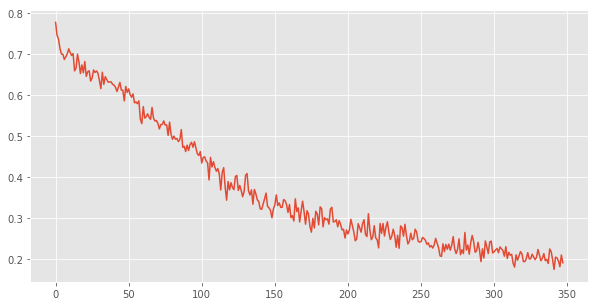

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(losses)

In [20]:
embeddor.most_similar("adore")

[('adore', 0.99999976),
 ('adored', 0.62502307),
 ('cherish', 0.55793297),
 ('adores', 0.55772871),
 ('love,', 0.55337274),
 ('love', 0.54610699),
 ('caress', 0.53535295),
 ('caresses', 0.53478605),
 ('adorable', 0.53415078),
 ('behold', 0.52701122)]